# Canucks - All Products
* StelllarAlgo Data Science
* Ryan Kazmerik & Nakisa Rad
* Jan 20, 2022

## Hypothesis

## Experiment
This section details our experiment including querying data, data transformations, feature selection and modelling.

In [1]:
import getpass
import pyodbc
import pandas as pd
import warnings
import matplotlib.pyplot as plt

from pycaret.classification import *

warnings.filterwarnings('ignore')

### Let's connect to MSSQL and run a stored proc to get our dataset:

In [2]:
# connect to SQL Server.
SERVER = '34.206.73.189' 
DATABASE = 'datascience' 
USERNAME = 'nrad' 
PASSWORD = getpass.getpass(prompt='Enter your password')
CNXN = pyodbc.connect('DRIVER={ODBC Driver 17 for SQL Server};SERVER='+SERVER+';DATABASE='+DATABASE+';UID='+USERNAME+';PWD='+ PASSWORD)

In [3]:
lkupclientid = 7 # Canucks
cursor = CNXN.cursor()

storedProc = (
    f"""Exec [stlrCanucks].[ds].[getRetentionScoringModelData] {lkupclientid}"""
)

df = pd.read_sql(storedProc, CNXN)

# apply some data transformations
df["year"] = pd.to_numeric(df["year"])

CNXN.commit()
cursor.close()

df.shape

(32923, 54)

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32923 entries, 0 to 32922
Data columns (total 54 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   lkupClientId            32923 non-null  int64  
 1   dimCustomerMasterId     32923 non-null  int64  
 2   customerNumber          32923 non-null  object 
 3   year                    32923 non-null  int64  
 4   productGrouping         32923 non-null  object 
 5   totalSpent              32923 non-null  float64
 6   recentDate              32923 non-null  object 
 7   attendancePercent       32923 non-null  float64
 8   renewedBeforeDays       32923 non-null  int64  
 9   isBuyer                 32923 non-null  object 
 10  source_tenure           32923 non-null  int64  
 11  tenure                  32923 non-null  int64  
 12  distToVenue             32923 non-null  float64
 13  totalGames              32923 non-null  int64  
 14  recency                 32923 non-null

### We should specify the features used in our model:

In [5]:
# choose the features for the stellar base retention model
features = [
                "dimCustomerMasterId",
                "attendancePercent",
                "distToVenue",
                "totalSpent",
                "recency",
                "source_tenure",
                "renewedBeforeDays",
                "isNextYear_Buyer",
                "productGrouping",
                "year"
]

# copy your main dataframe
df_dataset = df

# choose the features & train year & test year
df_dataset = df_dataset[features]
df_dataset["year"] = pd.to_numeric(df_dataset["year"])
df_dataset = df_dataset.loc[df_dataset["year"] <= 2019]

df_train = df_dataset.sample(frac=0.85, random_state=786)
df_eval = df_dataset.drop(df_train.index)

df_train.reset_index(drop=True, inplace=True)
df_eval.reset_index(drop=True, inplace=True)

# print out the number of records for training and eval
print('Data for Modeling: ' + str(df_train.shape))
print('Unseen Data For Predictions: ' + str(df_eval.shape), end="\n\n")

Data for Modeling: (23643, 10)
Unseen Data For Predictions: (4172, 10)



### Now we can model the data using a binary classification prediction for the isnextyear_buyer field to see how likely a customer is to re-purchase.

In [6]:
setup(
    data= df_train, 
    target="isNextYear_Buyer", 
    train_size = 0.85,
    data_split_shuffle=True,
    ignore_features=["dimCustomerMasterId","productGrouping","year"],
    silent=True,
    verbose=False,
    numeric_features=[
        "attendancePercent",
                "distToVenue",
                "totalSpent",
                "recency",
                "source_tenure",
                "renewedBeforeDays"
    ]
);

In [7]:
model_matrix = compare_models(
    fold=10,
    include=["lr", "xgboost"]
)

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
xgboost,Extreme Gradient Boosting,0.8092,0.8871,0.8349,0.8038,0.8190,0.6175,0.6180,0.5250
lr,Logistic Regression,0.6492,0.7113,0.6581,0.6637,0.6598,0.2976,0.2986,0.3020


In [8]:
best_model = create_model(model_matrix)
final_model = finalize_model(best_model)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,0.8000,0.8770,0.8317,0.7921,0.8114,0.5988,0.5996
1,0.8169,0.8942,0.8508,0.8058,0.8277,0.6327,0.6338
2,0.8134,0.8876,0.8373,0.8086,0.8227,0.6260,0.6264
3,0.8124,0.8902,0.8373,0.8071,0.8219,0.6240,0.6244
4,0.8100,0.8882,0.8258,0.8102,0.8179,0.6192,0.6193
5,0.8179,0.8920,0.8460,0.8101,0.8277,0.6348,0.6355
6,0.8113,0.8939,0.8296,0.8102,0.8198,0.6219,0.6221
7,0.7964,0.8822,0.8210,0.7928,0.8066,0.5918,0.5922
8,0.8253,0.9006,0.8450,0.8221,0.8334,0.6498,0.6501
9,0.7885,0.8652,0.8239,0.7796,0.8011,0.5755,0.5765


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Library/Frameworks/Py

### Let's load in our 2021 season data and get retention scores using the model:

In [9]:
df_inference = df.loc[df["year"] >= 2021]
df_inference = df_inference[df_inference["productGrouping"] ==  'Full Season' ]
df_inference = df_inference.fillna(0)
df_inference.shape

(3074, 54)

In [10]:
new_predictions = predict_model(final_model, data=df_inference, raw_score=True)
new_predictions.head()

,lkupClientId,dimCustomerMasterId,customerNumber,year,productGrouping,totalSpent,recentDate,attendancePercent,renewedBeforeDays,isBuyer,...,education,urbanicity,credits_after_refund,is_Lockdown,NumberofGamesPerSeason,CNTPostponedGames,isNextYear_Buyer,Label,Score_0,Score_1
27815,7,1244,1949481,2021,Full Season,9448.3,2021-12-14,1.055556,48,TRUE,...,0,0,0.0,1,46,0,0,0,0.8415,0.1585
27819,7,6018,8331009,2021,Full Season,6622.7,2021-12-14,0.950000,102,TRUE,...,0,0,0.0,1,46,0,0,0,0.8884,0.1116
27821,7,6453,1668905,2021,Full Season,8428.6,2021-12-14,0.888889,102,TRUE,...,0,0,0.0,1,46,0,0,0,0.9410,0.0590
27822,7,6661,415265,2021,Full Season,12784.4,2021-12-14,1.000000,102,TRUE,...,0,0,0.0,1,46,0,0,0,0.8528,0.1472
27823,7,7032,141998,2021,Full Season,9448.3,2021-12-14,1.055556,102,TRUE,...,0,0,0.0,1,46,0,0,0,0.9884,0.0116


In [11]:
new_predictions["Label"].value_counts()

0    2732
1     342
Name: Label, dtype: int64

In [12]:
new_predictions["Score_1"].value_counts(bins=[0, 0.2, 0.4, 0.6, 0.8, 1.0])

(-0.001, 0.2]    2108
(0.2, 0.4]        494
(0.4, 0.6]        248
(0.6, 0.8]        160
(0.8, 1.0]         64
Name: Score_1, dtype: int64

array([[<AxesSubplot:title={'center':'Score_1'}>]], dtype=object)

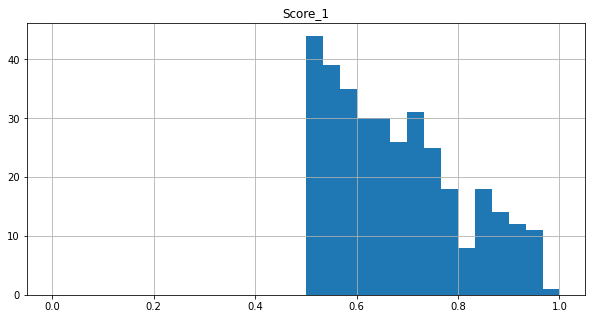

In [13]:
new_predictions[new_predictions["Label"]==1][["Score_1"]].hist(bins=30, figsize=(10,5), range=[0,1])

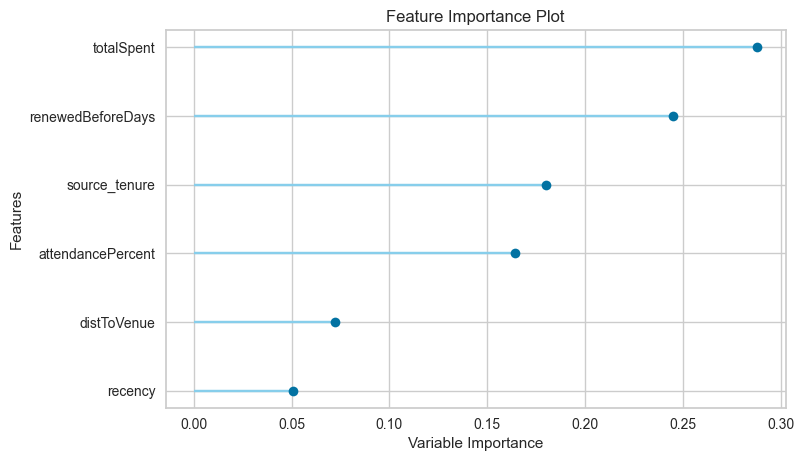

In [14]:
plot_model(best_model, plot='feature')

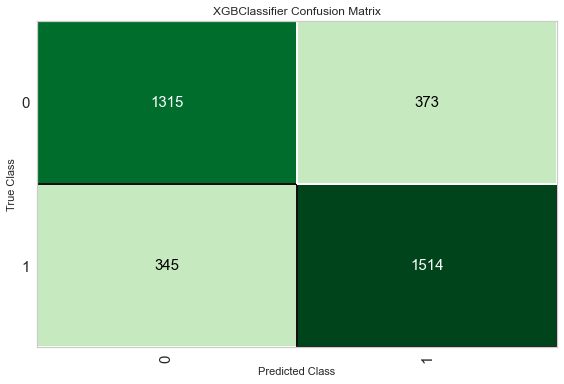

In [15]:
plot_model(best_model, plot='confusion_matrix')

## Observations
Here you can document some ideas on the results from above

## Conclusions
Here you can talk about next steps, did the experiment work? If yes, what to do next? If no, why?